In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split, RepeatedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNetCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.gaussian_process import GaussianProcessRegressor
import catboost as cb
from xgboost import XGBRegressor
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## Загружаем датасет для моделирования на цель "Модуль упругости на растяжение"

In [3]:
data_elasticity = pd.read_csv('../../data/data_for_model/elasticity_on_stretching_data_to_use.csv', sep=';', index_col=[0])
data_elasticity

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,73.333333,4.029126,1880.000000,111.860000,22.267857,284.615385,220.000000,1,4.000000,279.881315,76.957677,121.275785
1,80.803222,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.070285,85.775121,146.039613
2,76.178075,2.499918,1942.595777,146.252208,23.081757,351.231874,226.222760,1,5.000000,384.144381,114.030162,90.397231
3,73.817067,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.424362,84.946656,114.010469
4,77.210762,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.307864,36.705334,121.275785
...,...,...,...,...,...,...,...,...,...,...,...,...
931,73.090961,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.260338,45.465881,90.442938
932,72.920827,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.177541,63.654329,106.233019
933,74.734344,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,198.863724,103.165218,140.097049
934,74.042708,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.153429,94.077815,117.054830


In [4]:
data_elasticity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   elasticity_on_stretching  936 non-null    float64
 1   matrix_filler_ratio       936 non-null    float64
 2   density                   936 non-null    float64
 3   hardener                  936 non-null    float64
 4   epoxid                    936 non-null    float64
 5   temperature               936 non-null    float64
 6   resin                     936 non-null    float64
 7   cover_angle               936 non-null    int64  
 8   cover_step                936 non-null    float64
 9   elasticity_boxcox         936 non-null    float64
 10  surface_density_boxcox    936 non-null    float64
 11  cover_strength_boxcox     936 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 95.1 KB


In [5]:
# Принудительно перемешиваем датасет случайным образом, чтобы далее не думать над настройками параметра shuffle у ряда методов.
data_elasticity = data_elasticity.sample(frac=1, random_state=42).reset_index(drop=True)
data_elasticity

,elasticity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,69.622224,3.607138,1931.763858,103.133201,24.476396,276.450352,202.786361,0,8.664552,291.401264,109.393572,46.568898
1,74.370869,2.607764,2009.034308,79.346850,21.874257,206.005128,174.349765,0,9.196451,128.694091,85.197025,95.345170
2,71.819606,3.370618,1987.384877,104.936709,20.032106,301.077077,86.569522,0,6.910745,159.508728,75.243747,83.299156
3,74.862468,2.340851,1969.874456,75.811435,23.129981,292.135656,243.561501,1,6.916144,124.302073,99.922075,77.966237
4,80.970959,3.625686,2063.129132,89.075581,21.844375,247.156750,137.760968,1,7.409399,421.293411,106.695729,110.175567
...,...,...,...,...,...,...,...,...,...,...,...,...
931,74.692191,3.324535,1884.474321,106.074955,20.409882,297.453359,247.845360,0,6.846999,239.330757,102.278524,72.853952
932,71.386446,3.266473,2031.435898,72.982087,18.701544,222.346500,191.693262,0,7.653181,455.207086,16.190336,76.727285
933,75.162208,2.313264,1855.680584,92.537215,24.901111,261.345443,227.843200,1,5.706272,448.189826,74.085107,102.318376
934,70.199234,3.016343,2079.295010,105.588808,25.181815,268.548003,166.876118,0,0.730260,462.982185,56.637746,182.023206


## Разбиваем исходный датасет на train и test выборки

In [6]:
y = data_elasticity[['elasticity_on_stretching']]
X = data_elasticity.drop(columns=['elasticity_on_stretching'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [7]:
X_train.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,2.936518,1972.828819,109.256465,22.280533,284.317126,218.219003,0.528244,6.831492,317.635507,73.951399,115.862590
std,0.890112,69.843186,27.235178,2.472002,40.689940,58.235812,0.499583,2.527083,123.919214,31.151164,27.029153
min,0.551508,1784.482245,35.599697,15.695894,179.374391,63.685698,0.000000,0.037639,2.185415,0.550851,45.625201
25%,2.336238,1924.535020,91.577056,20.576246,256.919148,179.753288,0.000000,5.045156,235.256577,52.290358,98.229153
50%,2.921002,1976.868448,108.846759,22.226455,282.265660,219.198882,1.000000,6.893973,322.640655,74.141507,116.328150
75%,3.548696,2018.930572,128.816754,24.102818,312.487103,256.760915,1.000000,8.439914,402.003221,99.086377,132.536758
max,5.314144,2150.337595,179.645962,28.907470,386.067992,359.052220,1.000000,13.653987,642.948709,155.347638,187.261670


In [8]:
X_test.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,2.926912,1976.722817,113.195781,22.138643,288.320055,215.941925,0.487544,7.070944,323.039681,76.564510,113.570587
std,0.902593,72.658869,27.203041,2.299040,37.633068,57.066536,0.500737,2.521222,127.891360,31.174519,28.266840
min,0.547391,1801.940695,35.620904,16.848536,199.654080,74.097866,0.000000,0.268756,15.630577,4.987102,43.833385
25%,2.279886,1923.566230,93.800024,20.496931,262.325518,176.945878,0.000000,5.204978,225.700872,55.325507,94.414468
50%,2.833719,1977.907503,113.386470,22.141560,289.808973,212.192244,0.000000,6.968698,325.604451,76.897987,111.833531
75%,3.604674,2025.551362,132.653525,23.647354,314.996125,257.768388,1.000000,8.772316,423.513397,99.557800,132.613610
max,5.210442,2161.565216,181.828448,28.955094,385.894771,356.925975,1.000000,13.732404,631.529133,147.534031,184.185610


## Временно "откладываем в сторону" категориальный признак (0 и 1) - Угол нашивки ('cover_angle')

In [9]:
cover_angle_train = pd.DataFrame(X_train.pop('cover_angle'))
cover_angle_test = pd.DataFrame(X_test.pop('cover_angle'))

# Проводим должные трансформации X-ов и создаём новые "синтетические" признаки

In [10]:
# Приводим к единому масштабу данных от 0 до 1
scaler_minmax = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_minmax.transform(X_train), index=X_train.index, columns=X_train.columns.tolist())

In [11]:
# Нормализуем по строкам (по наблюдениям = горизонтально), а не по признакам (вертикально), т.к. по признакам корреляция с целевой переменной незначительная
scaler_normalize = Normalizer().fit(X_train)
X_train_norm = pd.DataFrame(scaler_normalize.transform(X_train), index=X_train.index, columns=[f'{col}_norm' for col in X_train.columns.tolist()])

### Попарное перемножение признаков

In [12]:
col_names = X_train.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_train_cross = []

for col_pair in col_pair_combinations:
    X_train_cross.append(X_train.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_train_cross = pd.DataFrame(X_train_cross).T
X_train_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

# Нормализуем получившиеся значения - приводим к масштабу данных в диапазоне [0-1]
scaler_minmax_for_cross = MinMaxScaler().fit(X_train_cross)
X_train_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_train_cross), index=X_train.index, columns=X_train_cross.columns.tolist())

### Добавляем ещё новые признаки, которые создаём через PCA - главные компоненты

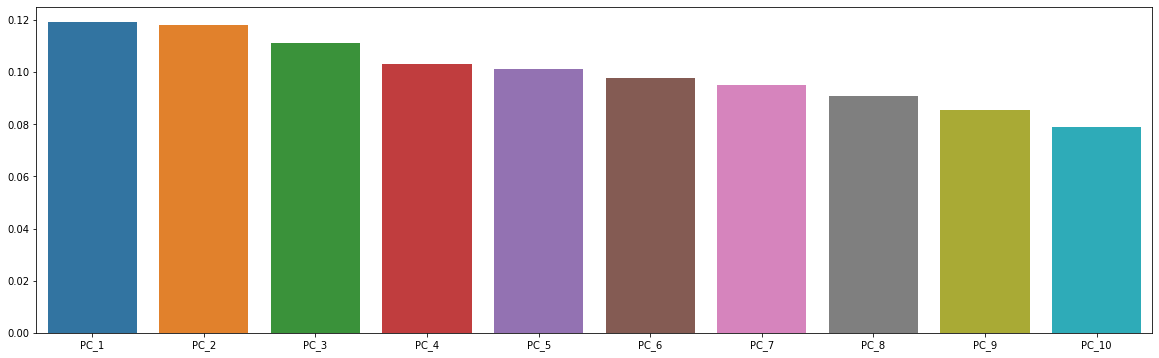

In [14]:
scaler_standard_for_pca = StandardScaler().fit(X_train)
X_train_standard = scaler_standard_for_pca.transform(X_train)

pca = PCA(random_state=42).fit(X_train_standard)
X_train_pca = pd.DataFrame(pca.transform(X_train_standard), index=X_train.index, columns=[f'PC_{i + 1}' for i in np.arange(X_train_standard.shape[1])])

plt.figure(figsize=(20, 6))
sns.barplot(x=X_train_pca.columns, y=pca.explained_variance_ratio_);

# X_train to use

In [24]:
# Собираем все train Х-ы вместе
X_train_to_use = pd.concat([X_train_scaled, X_train_norm, X_train_cross_scaled, X_train_pca, cover_angle_train], axis=1).reset_index(drop=True)
X_train_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.128970,0.686396,0.473507,0.222626,0.620508,0.235954,0.545479,0.513295,0.617759,0.223454,...,1.975584,-0.852777,-0.556348,0.078312,1.794924,0.032345,-0.453888,0.325083,-1.033411,0
1,0.230154,0.892438,0.460517,0.285116,0.307430,0.366758,0.427627,0.030359,0.632778,0.566734,...,0.863466,1.430552,-0.531118,-1.015212,0.995691,0.656146,1.531508,0.906868,-0.375738,1
2,0.473587,0.669157,0.271378,0.877765,0.228268,0.531700,0.000000,0.648091,0.545149,0.519645,...,0.390458,1.549873,0.172866,-1.310036,-2.052763,-0.700608,-2.032029,-0.072023,1.384844,1
3,0.626930,0.448068,0.043643,0.303159,0.298089,0.585117,0.334771,0.603180,0.444173,0.681737,...,-1.134737,0.597556,0.474087,1.162385,-0.300129,-1.792247,-0.167679,-0.242323,1.364632,0
4,0.730188,0.261081,0.529415,0.497440,0.509164,0.529221,0.291000,0.433383,0.493594,0.534118,...,-0.014156,0.079723,0.508883,-0.040555,-0.782484,-0.617630,0.713681,-1.425249,0.788499,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0.512713,0.576465,0.355608,0.399258,0.518213,0.434349,0.501092,0.807260,0.459479,0.569185,...,-0.680253,-0.840677,-0.471425,0.560117,0.051890,-0.638864,-1.103554,-0.122976,0.165693,1
651,0.344471,0.411857,0.416318,0.802082,0.594360,0.497604,0.898989,0.660992,0.397567,0.427309,...,0.094400,-0.165779,-0.266586,1.511217,0.449472,1.352936,-1.589150,1.017677,0.174536,0
652,0.156879,0.845854,0.533551,0.310231,0.384264,0.450914,0.537908,0.592962,0.386121,0.608802,...,-0.084589,-0.791286,-0.392999,-0.354483,0.233013,0.390519,-0.227031,1.692321,-0.740698,1
653,0.529494,0.372824,0.656486,0.646347,0.676401,0.398263,0.280088,0.528229,0.317325,0.425090,...,0.572961,-0.691053,0.970951,-0.594982,-0.761443,0.624501,-0.492960,-1.245895,0.015807,1


# Применяем все те же трансформации к X_test

In [16]:
# MinMax Re-scale (feature-wise)
X_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), index=X_test.index, columns=X_test.columns)

In [17]:
# Normalize (sample-wise)
X_test_norm = pd.DataFrame(scaler_normalize.transform(X_test), index=X_test.index, columns=[f'{col}_norm' for col in X_test.columns.tolist()])

In [18]:
# Multiply (cross-effects)

col_names = X_test.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_test_cross = []

for col_pair in col_pair_combinations:
    X_test_cross.append(X_test.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_test_cross = pd.DataFrame(X_test_cross).T
X_test_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

X_test_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_test_cross), index=X_test_cross.index, columns=X_test_cross.columns.tolist())

In [19]:
# Apply PCA
X_test_standard = scaler_standard_for_pca.transform(X_test)
X_test_pca = pd.DataFrame(pca.transform(X_test_standard), index=X_test.index, columns=[f'PC_{i + 1}' for i in np.arange(X_test.shape[1])])

# X_test to use

In [20]:
X_test_to_use = pd.concat([X_test_scaled, X_test_norm, X_test_cross_scaled, X_test_pca, cover_angle_test], axis=1).reset_index(drop=True)
X_test_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.534349,0.699040,0.922876,0.281681,0.726403,0.619504,0.693163,0.381687,0.948269,0.904053,...,-1.098221,-1.192925,-2.421192,-1.936896,1.460092,0.413321,2.197777,0.492464,0.379056,0
1,0.697807,0.502319,0.728347,0.404458,0.276604,0.392691,0.351997,0.718501,0.795287,0.486310,...,0.443591,-0.539872,-2.018707,-0.467297,-1.342202,-1.254879,0.358455,-0.868471,-0.078999,1
2,0.455593,0.606658,0.281432,0.597825,0.400061,0.334832,0.480082,0.726689,0.737742,0.127157,...,1.563137,0.736973,-1.215750,0.570339,0.215855,-0.975805,-2.025542,-0.298246,-0.271302,0
3,0.331852,0.590065,0.623892,0.561923,0.340896,0.717675,0.762579,0.890627,0.616767,0.580304,...,-0.414795,-1.011409,-1.574158,0.287976,-0.487455,-0.393763,-0.873852,2.178809,0.033378,1
4,0.526507,0.381888,0.427128,0.410221,0.517325,0.454015,0.433070,0.710102,0.598639,0.358464,...,0.667781,-0.615209,-0.340990,0.552158,0.024550,-1.126862,-0.641826,-0.605594,0.235932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,0.648211,0.744355,0.494155,0.496800,0.401684,0.803489,0.715897,0.424995,0.466420,0.467453,...,-1.229722,1.181545,-0.386941,-0.019410,0.306166,-0.462397,0.253692,1.062220,-0.989883,0
277,0.336609,0.630568,0.602551,0.680267,0.445221,0.457253,0.237313,0.434023,0.285368,0.656592,...,0.057059,0.021992,0.807084,-1.247038,-1.216550,1.135323,-0.294750,0.267243,0.346676,1
278,0.376310,0.286595,0.477806,0.650536,0.534291,0.564999,0.668369,0.309321,0.274765,0.404692,...,0.593587,0.373380,1.214658,1.074155,0.126009,1.108800,0.192300,0.495506,0.122454,0
279,0.609182,0.229234,0.359518,0.577261,0.541694,0.559393,0.370526,0.405963,0.398675,0.372115,...,0.500791,0.563971,1.254427,0.653777,-0.270226,-0.449476,-0.044572,-0.974120,0.688744,0


In [25]:
X_train_to_use.shape, X_test_to_use.shape

((655, 76), (281, 76))

In [21]:
# Распределение целевой переменной test vs. train сильно отличается по количеству значений в диапазоне 72-75, что смущает / настораживает.

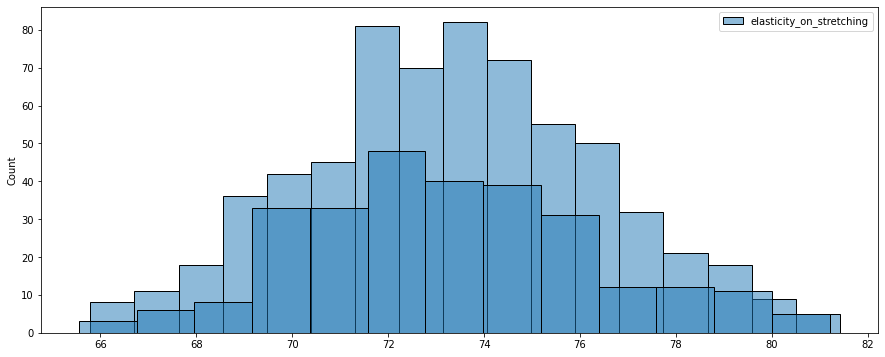

In [26]:
plt.figure(figsize=(15, 6))
sns.histplot(y_train)
sns.histplot(y_test);

In [27]:
y_train.var(), y_test.var(),

(elasticity_on_stretching    9.231189
 dtype: float64,
 elasticity_on_stretching    9.164253
 dtype: float64)

In [28]:
y_train.mean(), y_test.mean(),

(elasticity_on_stretching    73.328715
 dtype: float64,
 elasticity_on_stretching    73.254415
 dtype: float64)

In [29]:
y_train.median(), y_test.median(),

(elasticity_on_stretching    73.389639
 dtype: float64,
 elasticity_on_stretching    72.895374
 dtype: float64)

In [ ]:
# for col_name in X_train_to_use.columns.tolist():
#     fig, ax = plt.subplots(1, 1, figsize=(15, 6))
#     sns.histplot(X_train_to_use[col_name])
#     sns.histplot(X_test_to_use[col_name])
#     plt.show()

# На всякий случай сверяем картину test vs. train по корреляции с целевой переменной.

### Расположение признаков по показателю и знаку корреляции по test vs. train разное, и это опять же настораживаем. Можно было бы предположить, что это из-за 30% доли test выборки, но аналогичная нестабильная/неоднородная картина и при делении 50%-на-50%.  

In [30]:
data_train_temp = pd.concat([y_train, X_train_to_use], axis=1)
data_test_temp = pd.concat([y_test, X_test_to_use], axis=1)

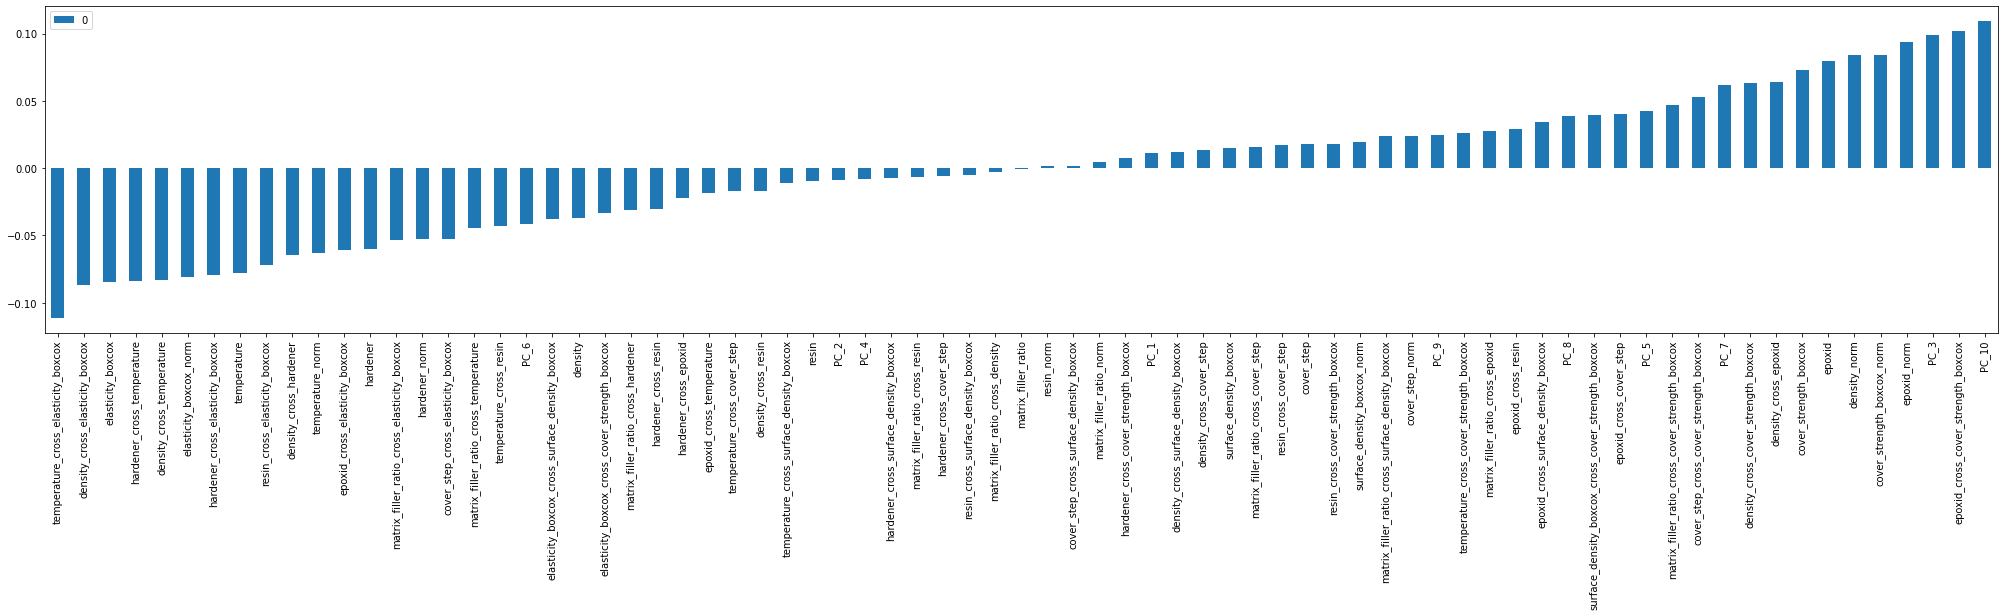

In [31]:
pd.DataFrame(data_train_temp.drop(columns=['cover_angle']).corrwith(data_train_temp['elasticity_on_stretching']).sort_values()[:-1]).plot(kind='bar', figsize=(35, 6));

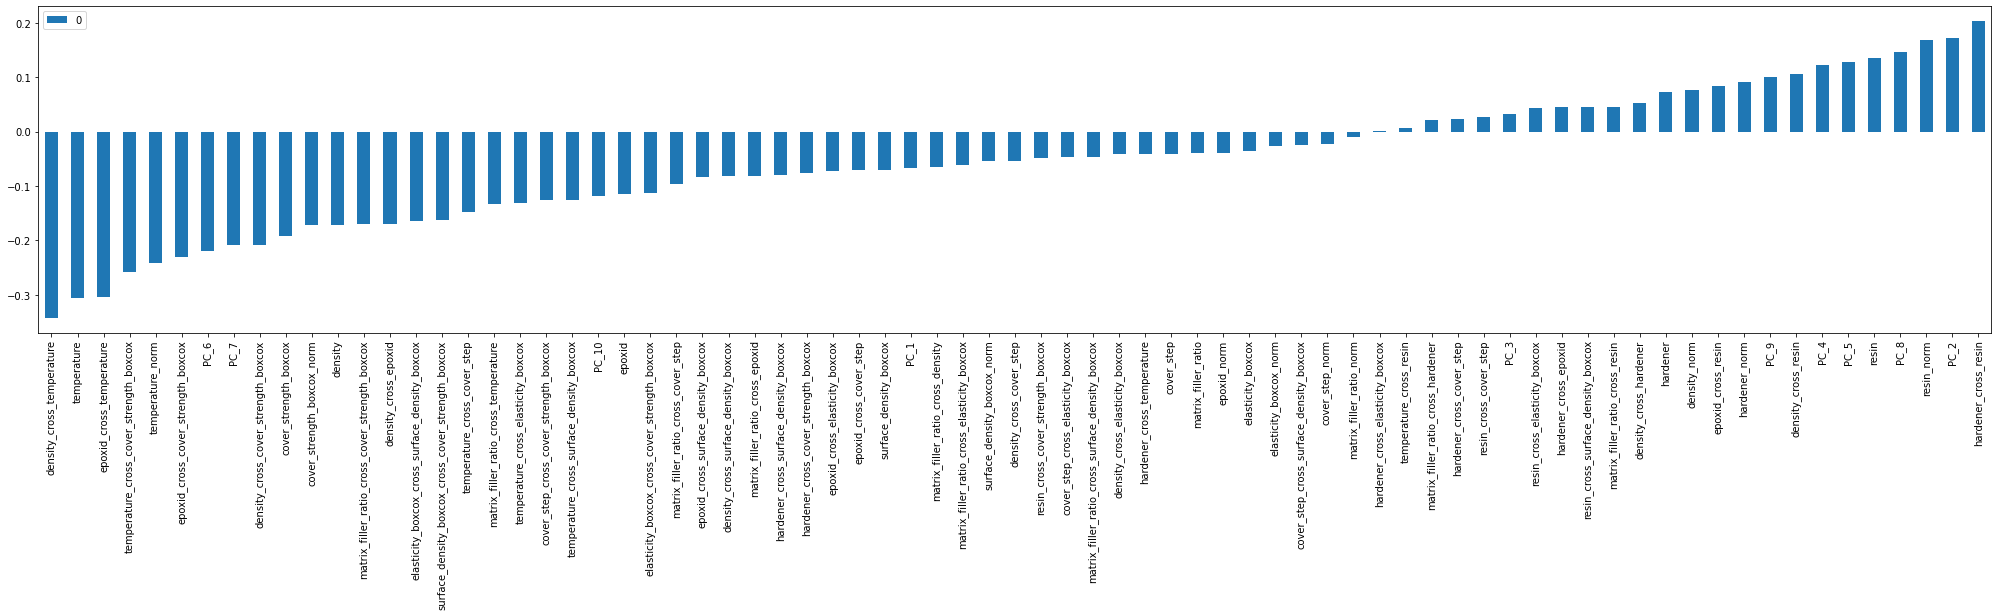

In [32]:
pd.DataFrame(data_test_temp.drop(columns=['cover_angle']).corrwith(data_test_temp['elasticity_on_stretching']).sort_values()[:-1]).plot(kind='bar', figsize=(35, 6));

# Сравнение результатов разных алгоритмов (это пока только первые расчёты, на которых всё и ломается - R2 по test-выборке стабильно лежит "ниже плинтуса")

### Model_1

In [33]:
# Была большая надежда на GaussianProcessRegressor, т.к. почти все исходные признаки показывали нормальную форму распределения.

gpr = GaussianProcessRegressor(n_restarts_optimizer=5, random_state=42).fit(X_train_to_use, y_train.values.ravel())

print(f'R2 train: {gpr.score(X_train_to_use, y_train.values.ravel())}')
print(f'R2 train: {gpr.score(X_test_to_use, y_test.values.ravel())}')

R2 train: 1.0
R2 train: -247.99024576287718


### Model_2

In [34]:
# В качестве дальнейшей разведки берём классику - Random Forest, предполагая, что он-то должен грубо (пока без тонкой настройки) обучить модель и 
# показать более-менее адекватный результат по test выборке, но нет - R2 по test отрицательный, и это беда...

model_forest = RandomForestRegressor(n_estimators=1000, max_features='auto', max_depth=5, criterion='squared_error', random_state=42)
model_forest.fit(X_train_to_use, y_train.values.ravel())

y_train_pred = model_forest.predict(X_train_to_use)
y_test_pred = model_forest.predict(X_train_to_use)

R2_train = model_forest.score(X_train_to_use, y_train.values.ravel())
R2_test = model_forest.score(X_test_to_use, y_test.values.ravel())

print(f'R2 train: {R2_train}')
print(f'R2 train: {R2_test}')

R2 train: 0.33227497828005903
R2 train: -0.05121619167474445


### Экспериментировал, как с разным набором признаков (с добавлением кросс-эффектов, возведение в степень, компонетны - с ними и без). так и со стандартизацией/нормализацией/нормированием - результат не меняется... R2 показатель по test выборке, либо ничточно мал, либо отрицательный ((( 

In [ ]:
# for col_name in data_elasticity.columns.tolist():
#     plt.figure(figsize=(10, 5))
#     sns.histplot(data_elasticity[col_name], bins=10);

In [ ]:
def assign_hist_bin_number(data, n_bins=10):
    _, binEdges = np.histogram(data, bins=n_bins)
    bin_numbers = [[i + 1  for i in np.arange(n_bins) if (x >= binEdges[i]) & (x < binEdges[i + 1])] for x in data]
    return bin_numbers

In [ ]:
# _, binEdges = np.histogram(data_elasticity['cover_strength_boxcox'], bins=10)
# list(binEdges)

In [ ]:
data_elasticity.columns

In [ ]:
data_elasticity = data_elasticity.astype('float64')

In [ ]:
# bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).dropna().reset_index(drop=True).apply(lambda x: sum(x, []), axis=1).to_frame()
bins = pd.DataFrame(data_elasticity.drop(columns=['cover_angle']).apply(assign_hist_bin_number, axis=0)).dropna().apply(lambda x: sum(x, []), axis=1).to_frame()
bins_df = bins[0].apply(pd.Series)
bins_df.columns = data_elasticity.drop(columns=['cover_angle']).columns
bins_df

In [ ]:
bins_df.isna().sum()

In [ ]:
nan_idx = bins_df[bins_df['cover_strength_boxcox'].isna()].index
nan_idx

In [ ]:
data_elasticity.loc[nan_idx, 'cover_strength_boxcox']

In [ ]:
bins_df.loc[136, 'cover_strength_boxcox'] = 10
bins_df.loc[176, 'cover_strength_boxcox'] = 2
bins_df.loc[182, 'cover_strength_boxcox'] = 7
bins_df.loc[185, 'cover_strength_boxcox'] = 8
bins_df.loc[497, 'cover_strength_boxcox'] = 4
bins_df.loc[618, 'cover_strength_boxcox'] = 7
bins_df.loc[632, 'cover_strength_boxcox'] = 6
bins_df.loc[666, 'cover_strength_boxcox'] = 4
bins_df.loc[758, 'cover_strength_boxcox'] = 5
bins_df.loc[761, 'cover_strength_boxcox'] = 5
bins_df.loc[813, 'cover_strength_boxcox'] = 7

In [ ]:
bins_df.isna().sum()

In [ ]:
y_bin_labels = bins_df['elasticity_on_stretching'].unique().astype(int)
y_bins_matched = {}
y_bins_missmatched = {}

counter = 0

for y_label in y_bin_labels:    
    subset = bins_df.loc[bins_df['elasticity_on_stretching'] == y_label, bins_df.columns[1:]]    
    for idx in subset.index:
        # counter += 1
        row_main = subset.loc[idx, :].values
        subset_2 = subset.drop(index=[idx])
        for idx_2 in subset_2.index:
            row_compare = subset_2.loc[idx_2, :].values
            if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
                y_bins_matched.setdefault(y_label, []).append((idx, idx_2))
            else:
                y_bins_missmatched.setdefault(y_label, []).append((idx, idx_2))

In [ ]:
# all_y_bins_matched = []
# all_y_bins_missmatched = []

# for idx in bins_df.index:
#     row_main = bins_df.loc[idx, :].values
#     subset = bins_df.drop(index=[idx])
#     for idx_2 in subset.index:
#         row_compare = subset.loc[idx_2, :].values
#         if np.sum(np.abs(np.subtract(row_main, row_compare))) == 0:
#             all_y_bins_matched.append((idx, idx_2))
#         else:
#             all_y_bins_missmatched.append((idx, idx_2))

In [ ]:
y_bins_matched

In [ ]:
y_bins_missmatched